In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.data import Data, Batch
from torch_geometric.utils.convert import from_networkx, to_networkx
import networkx as nx
from scipy import sparse as sp

from models import NodeClassificationGraphTransformer, GraphTransformerEdges, GraphTransformer, GraphRepresentationGraphTransformer
from preprocess import AddLaplacianPosEncoding, AddWLPosEncoding, MakeFullGraph
from train import train_one_epoch, evaluate

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


In [3]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 2 # 2 / 10

# Training parameters
BATCH_SIZE = 32
INIT_LR = 0.0005
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 10
MIN_LR = 1e-6
EPOCHS = 50

# Network parameters
n_hidden = 80
n_head = 8
n_feedforward = 160
n_layers = 4
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'

In [4]:
transforms = T.Compose([
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    AddWLPosEncoding(),
    #MakeFullGraph(),
    T.AddSelfLoops('edge_attr')
])

# Generate a list of 10 cycle graphs with sizes ranging from 10 to 20
cycle_graphs = [nx.cycle_graph(num_nodes) for num_nodes in range(10, 20)]

graphs = [nx.house_graph(), nx.cycle_graph(10), nx.grid_graph((3,3)), nx.star_graph(10), nx.path_graph(10)]

In [5]:
def house_graph():
    g = nx.house_graph()
    t_g = from_networkx(g)
    t_g.remove_tensor('name')
    return nx.Graph(to_networkx(t_g))

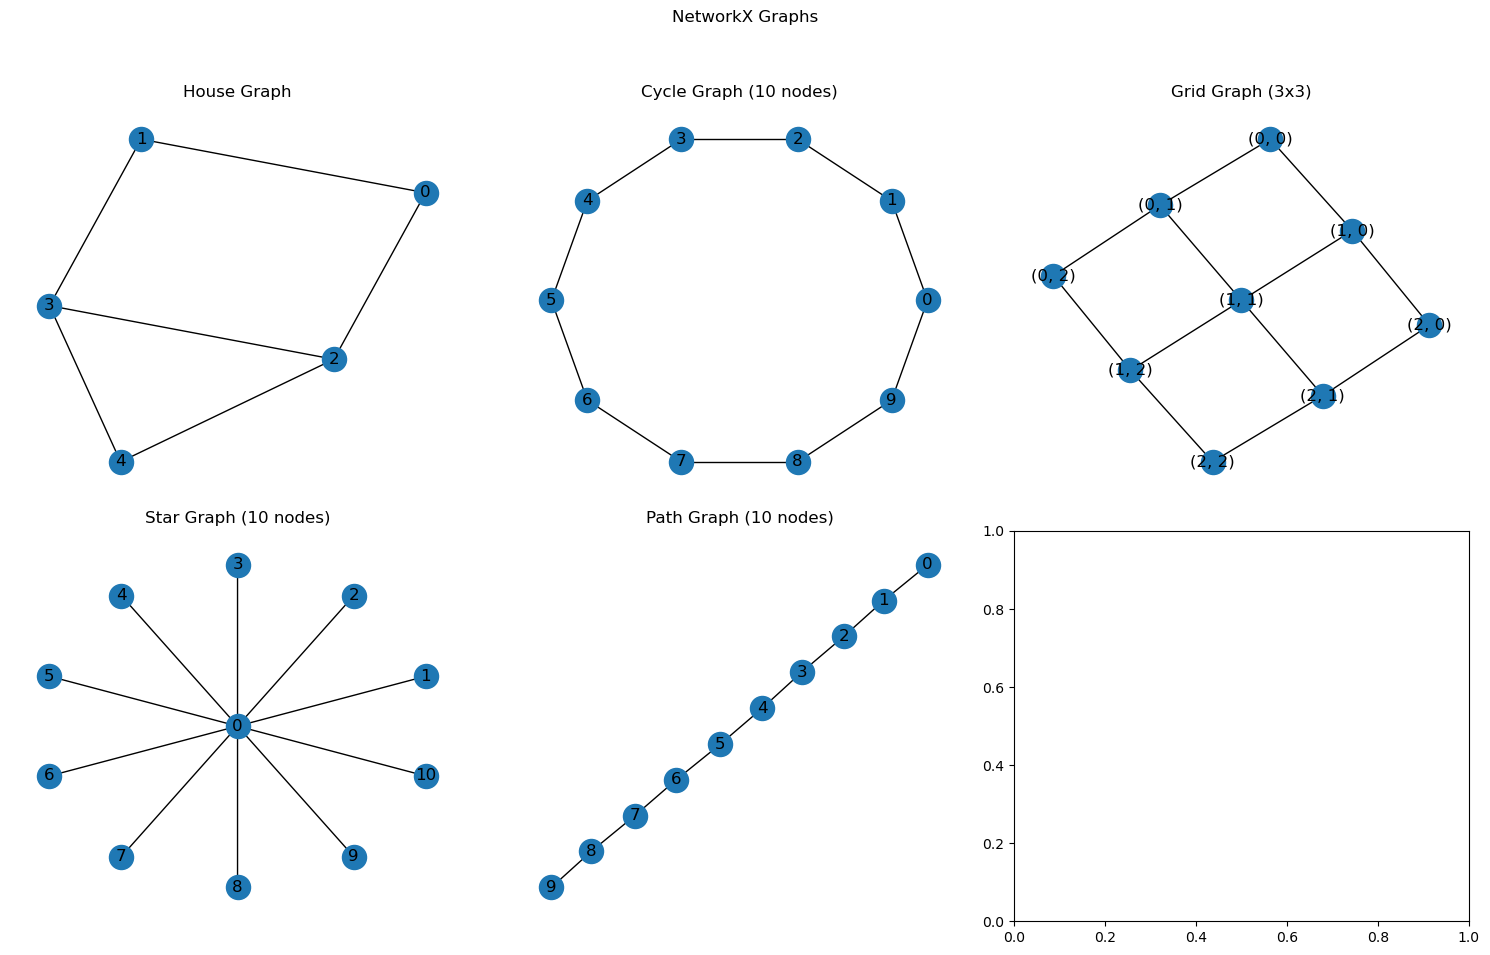

In [6]:
# List of graphs
graphs = [house_graph(), nx.cycle_graph(10), nx.grid_graph((3, 3)), nx.star_graph(10), nx.path_graph(10)]
graph_names = ['House Graph', 'Cycle Graph (10 nodes)', 'Grid Graph (3x3)', 'Star Graph (10 nodes)', 'Path Graph (10 nodes)']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('NetworkX Graphs')

# Plot each graph in a subplot
for i, ax in enumerate(axes.flatten()[:-1]):
    graph = graphs[i]
    name = graph_names[i]

    nx.draw_kamada_kawai(graph, with_labels=True, ax=ax)
    ax.set_title(name)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

In [7]:
# Convert NetworkX graphs to PyTorch Geometric format
torch_geometric_graphs = [transforms(from_networkx(graph)) for graph in graphs]

# Create a batch from the list of graphs
batch = Batch.from_data_list(torch_geometric_graphs)
batch

/media/cedric/Stockage1/Documents/Cours/MVA/Semestre1/Geometric data analysis/Projet/code/Graph-Transformers/preprocess.py:15: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  EigVec = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()


DataBatch(edge_index=[2, 139], num_nodes=45, laplacian_eigs=[45, 2], wl_encoding=[45], batch=[45], ptr=[6])

In [8]:
g = torch_geometric_graphs[0]
g

Data(edge_index=[2, 17], num_nodes=5, laplacian_eigs=[5, 2], wl_encoding=[5])

In [9]:
g.wl_encoding

tensor([1, 1, 2, 2, 1])

In [10]:
g.laplacian_eigs

tensor([[-5.5709e-01,  5.0000e-01],
        [-5.5709e-01, -5.0000e-01],
        [ 1.8570e-01,  5.0000e-01],
        [ 1.8570e-01, -5.0000e-01],
        [ 5.5709e-01,  2.9547e-08]])

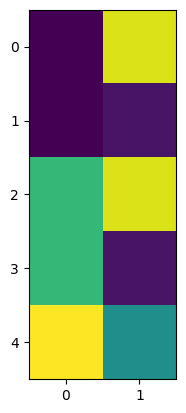

In [11]:
plt.imshow(g.laplacian_eigs.numpy())

In [12]:
batch = Batch.from_data_list([g])
batch

DataBatch(edge_index=[2, 17], num_nodes=5, laplacian_eigs=[5, 2], wl_encoding=[5], batch=[5], ptr=[2])

In [48]:
# Features
#batch.x = torch.ones(batch.num_nodes, dtype=torch.long)
batch.x = batch.wl_encoding

In [49]:
model = GraphTransformer(batch.num_nodes, 8, 2, 16, 1, 0.0, 0.0, 2, None, 'layer')

In [50]:
out, attention_scores = model(batch, batch.x, batch.wl_encoding)

In [51]:
out.detach().cpu()

tensor([[ 1.9582, -0.0709,  0.9647, -0.8861, -1.0228, -0.8256, -0.6544,  0.5370],
        [ 1.9582, -0.0709,  0.9647, -0.8861, -1.0228, -0.8256, -0.6544,  0.5370],
        [-2.0802,  0.3233,  1.1259,  1.3349, -0.4870, -0.4741,  0.2375,  0.0197],
        [-2.0802,  0.3233,  1.1259,  1.3349, -0.4870, -0.4741,  0.2375,  0.0197],
        [ 1.9644, -0.0307,  0.9195, -0.6391, -0.8299, -1.1160, -0.8107,  0.5425]])

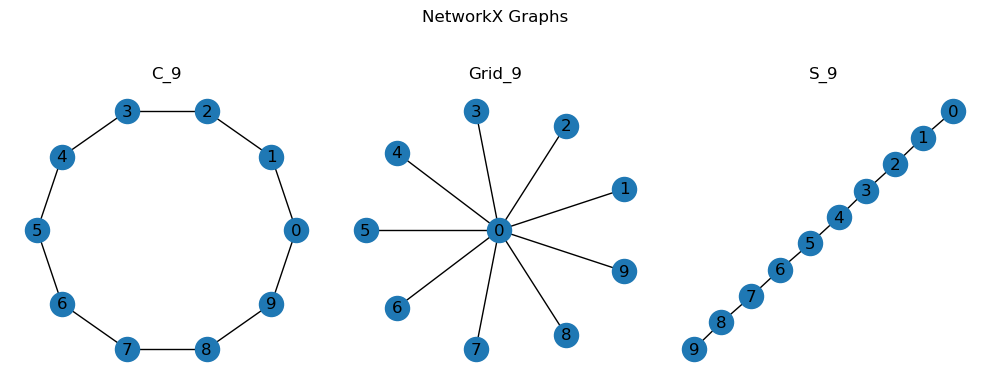

In [9]:
# List of graphs
graphs = [nx.cycle_graph(10), nx.star_graph(9), nx.path_graph(10)]
graph_names = ['C_9', 'Grid_9', 'S_9', 'L_9']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('NetworkX Graphs')

# Plot each graph in a subplot
for i, ax in enumerate(axes.flatten()):
    graph = graphs[i]
    name = graph_names[i]

    nx.draw_kamada_kawai(graph, with_labels=True, ax=ax)
    ax.set_title(name)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

In [10]:
torch_geometric_graphs = [transforms(from_networkx(graph)) for graph in graphs]

/media/cedric/Stockage1/Documents/Cours/MVA/Semestre1/Geometric data analysis/Projet/code/Graph-Transformers/preprocess.py:15: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  EigVec = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()


In [11]:
g = torch_geometric_graphs[2]
batch = Batch.from_data_list([g])
batch

DataBatch(edge_index=[2, 28], num_nodes=10, laplacian_eigs=[10, 6], wl_encoding=[10], batch=[10], ptr=[2])

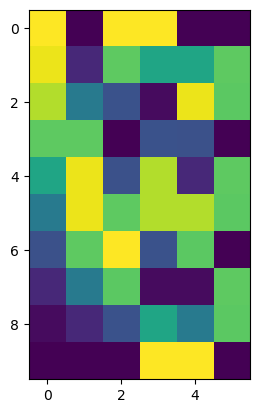

In [12]:
plt.imshow(g.laplacian_eigs.numpy())

In [18]:
g.wl_encoding.shape

torch.Size([10])

In [15]:
g.num_nodes

10

In [17]:
torch.arange(0, g.num_nodes, dtype=torch.float).unsqueeze(1).shape

torch.Size([10, 1])

In [20]:
d = 16

In [26]:
pe = torch.zeros(g.num_nodes, d)
wl_code = g.wl_encoding.unsqueeze(1)
div_term = torch.exp(
            torch.arange(0, d, 2).float() * (-np.log(10000.0) / d)
        )
pe[:, 0::2] = torch.sin(wl_code * div_term)
pe[:, 1::2] = torch.cos(wl_code * div_term)
pe

tensor([[ 9.0930e-01, -4.1615e-01,  5.9113e-01,  8.0658e-01,  1.9867e-01,
          9.8007e-01,  6.3203e-02,  9.9800e-01,  1.9999e-02,  9.9980e-01,
          6.3245e-03,  9.9998e-01,  2.0000e-03,  1.0000e+00,  6.3246e-04,
          1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  3.1098e-01,  9.5042e-01,  9.9833e-02,
          9.9500e-01,  3.1618e-02,  9.9950e-01,  9.9998e-03,  9.9995e-01,
          3.1623e-03,  9.9999e-01,  1.0000e-03,  1.0000e+00,  3.1623e-04,
          1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  3.1098e-01,  9.5042e-01,  9.9833e-02,
          9.9500e-01,  3.1618e-02,  9.9950e-01,  9.9998e-03,  9.9995e-01,
          3.1623e-03,  9.9999e-01,  1.0000e-03,  1.0000e+00,  3.1623e-04,
          1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  3.1098e-01,  9.5042e-01,  9.9833e-02,
          9.9500e-01,  3.1618e-02,  9.9950e-01,  9.9998e-03,  9.9995e-01,
          3.1623e-03,  9.9999e-01,  1.0000e-03,  1.0000e+00,  3.1623e-04,
          1.0000e+00],
        [ 8.4147e-01

In [52]:
model = GraphRepresentationGraphTransformer(2,8,1,32,1,0.0,0.0,k=POS_ENCODING_DIM,pos_encoding=None, norm=None, readout='mean')

Accepted values for norm: 'layer' and 'batch'. Proceeding without normalization layers.


In [53]:
model(batch, batch.x)

IndexError: index out of range in self

In [ ]:
C1_batch = Batch.from_data_list([torch_geometric_graphs[0]])
#C1_batch.x = torch.ones(C1_batch.num_nodes, dtype=torch.long)
C1_batch.x = torch.range(0, C1_batch.num_nodes-1, dtype=torch.long)
C1_batch

/tmp/ipykernel_65935/744447651.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  C1_batch.x = torch.range(0, C1_batch.num_nodes-1, dtype=torch.long)


DataBatch(edge_index=[2, 30], num_nodes=10, laplacian_eigs=[10, 4], wl_encoding=[10], batch=[10], ptr=[2], x=[10])

In [ ]:
model = GraphTransformer(10, 16, 4, 20, 1, 0.0, 0.0, POS_ENCODING_DIM, None, 'layer')

In [ ]:
model(C1_batch, C1_batch.x, precomputed_eigenvectors=C1_batch.laplacian_eigs)

tensor([[ 0.8744,  0.8175,  0.1311,  2.1191, -0.0109,  0.7796, -0.3331,  0.2649,
         -2.2398, -1.1661, -0.5722,  0.4417, -0.9872, -0.8004,  0.8526, -0.1711],
        [-0.7642,  0.8023,  0.3971,  0.5484, -0.6432,  0.4756, -0.4252, -0.6157,
         -0.8927, -0.9772, -1.1636,  0.8466,  0.0209, -0.7109,  2.9607,  0.1410],
        [ 0.3244,  1.4638,  0.1671,  0.3382, -0.9442,  2.1668, -0.2917,  0.1419,
          0.1705,  1.1821, -2.1135, -0.9452, -0.0990, -0.0895, -0.8597, -0.6119],
        [ 0.1975, -0.5398,  1.4378,  1.1986,  1.9914, -0.1182,  0.4058, -0.3679,
         -0.9690, -1.6570, -0.2837,  1.0925, -1.0096, -1.3405, -0.2532,  0.2153],
        [-0.5597, -0.1875, -1.3227,  1.9313, -0.9928, -0.1840,  0.1064,  1.0283,
         -0.0803, -0.8687,  1.1626,  1.5618,  0.1491, -1.6495,  0.5790, -0.6732],
        [ 0.5058,  0.2113,  1.3642,  0.4414,  0.4104, -0.5587, -0.4222,  0.2186,
         -0.6752, -1.8546, -0.3212,  1.0556,  1.4814, -0.4556,  0.7894, -2.1906],
        [-0.7001,  0.9

In [ ]:
C1_batch.x

In [73]:
G1 = nx.empty_graph(6)
nx.add_cycle(G1, [0,1,2])
nx.add_cycle(G1, [3,4,5])

G2 = nx.cycle_graph(6)

# Convert NetworkX graphs to PyTorch Geometric format
torch_geometric_graphs = [transforms(from_networkx(G1)), transforms(from_networkx(G2))]

# Create a batch from the list of graphs
batch = Batch.from_data_list(torch_geometric_graphs)
batch.x = torch.ones(batch.num_nodes, dtype=torch.long)
#batch.x = torch.range(0, batch.num_nodes-1, dtype=torch.long)
batch

DataBatch(edge_index=[2, 36], num_nodes=12, laplacian_eigs=[12, 2], wl_encoding=[12], batch=[12], ptr=[3], x=[12])

In [ ]:
GraphRepresentationGraphTransformer()

In [76]:
model = GraphRepresentationGraphTransformer(2,8,1,16,1,0.0,0.0,k=POS_ENCODING_DIM,pos_encoding='laplacian', norm=None, readout='mean')

Accepted values for norm: 'layer' and 'batch'. Proceeding without normalization layers.


In [77]:
out, _ = model(batch, batch.x, precomputed_eigenvectors=batch.laplacian_eigs)
out

tensor([[ 0.0870,  0.4767, -1.7000, -0.8588, -2.1322, -0.4495, -1.1950, -1.5174],
        [ 0.0422,  0.4596, -1.7044, -0.9622, -2.2276, -0.4780, -1.1393, -1.3999]],
       grad_fn=<DivBackward0>)

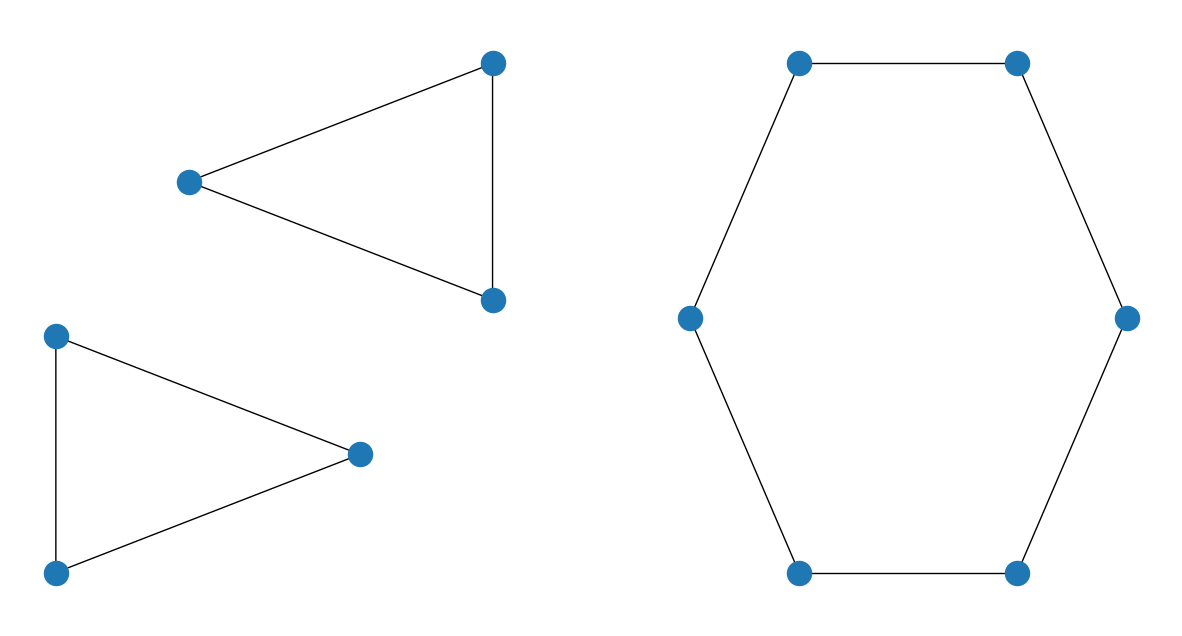

In [72]:
plt.figure(figsize=(15,8))
G3 = nx.empty_graph(6)
nx.add_cycle(G3, [0,1,4,5])
nx.add_path(G3, [1,2,3,4])
plt.subplot(1,2,1)
nx.draw_kamada_kawai(G1)


G4 = nx.empty_graph(6)
nx.add_cycle(G4, [0,1,5])
nx.add_cycle(G4, [2,3,4])
nx.add_path(G4, [1,4])
plt.subplot(1,2,2)
nx.draw_kamada_kawai(G2)
plt.show()

In [64]:
torch_geometric_graphs = [transforms(from_networkx(G3)), transforms(from_networkx(G4))]

batch = Batch.from_data_list(torch_geometric_graphs)
batch.x = torch.ones(batch.num_nodes, dtype=torch.long)
#batch.x = torch.range(0, batch.num_nodes-1, dtype=torch.long)
batch

DataBatch(edge_index=[2, 40], num_nodes=12, laplacian_eigs=[12, 2], wl_encoding=[12], batch=[12], ptr=[3], x=[12])

In [66]:
model = GraphRepresentationGraphTransformer(2,8,1,16,1,0.0,0.0,k=POS_ENCODING_DIM,pos_encoding='wl', norm=None, readout='mean')

out, _ = model(batch, batch.x, precomputed_eigenvectors=batch.wl_encoding)
out

Accepted values for norm: 'layer' and 'batch'. Proceeding without normalization layers.


tensor([[-0.1844, -0.5413, -0.5375, -0.7120,  0.5620,  0.5114, -1.2515,  0.3844],
        [-0.1844, -0.5413, -0.5375, -0.7120,  0.5620,  0.5114, -1.2515,  0.3844]],
       grad_fn=<DivBackward0>)

In [ ]:
model.